In [72]:
import pandas as pd
import networkx as nx

df = pd.read_csv("../data/2021-04_cleaned.csv")

df = df.rename(columns={
    "Departure": "departure_time",
    "Return": "return_time",
    "Departure station id": "dep_id",
    "Departure station name": "dep_name",
    "Return station id": "ret_id",
    "Return station name": "ret_name",
    "Covered distance (m)": "distance_m",
    "Duration (sec.)": "duration_s",
    "Departure_lat": "dep_lat",
    "Departure_lon": "dep_lon",
    "Return_lat": "ret_lat",
    "Return_lon": "ret_lon",
    "Speed_kmh": "speed_kmh",
    "new_duration": "new_duration",            
    "time_window": "time_window",# keeps the temporal label
    "day_type": "day_type",                    # weekday/weekend
})

df = df[(df["distance_m"] > 0) & (df["duration_s"] > 0)]
df = df.dropna(subset=["dep_id", "ret_id"])

G = nx.DiGraph()

for _, row in df[["dep_id", "dep_name"]].drop_duplicates().iterrows():
    G.add_node(row["dep_id"], name=row["dep_name"])

for _, row in df[["ret_id", "ret_name"]].drop_duplicates().iterrows():
    G.add_node(row["ret_id"], name=row["ret_name"])

agg = df.groupby(["dep_id", "ret_id"]).agg(trip_count=("dep_id", "size"),
    total_distance=("distance_m", "sum"), total_duration=("duration_s", "sum")).reset_index()

for _, r in agg.iterrows():
    G.add_edge(r["dep_id"], r["ret_id"], weight=r["trip_count"],
               total_distance=r["total_distance"], total_duration=r["total_duration"])

print("Number of nodes (stations):", G.number_of_nodes())
print("Number of edges (station pairs):", G.number_of_edges())
print("Total trips:", df.shape[0])
print("Average trip distance (m):", df["distance_m"].mean())
print("Average trip duration (s):", df["duration_s"].mean())

in_deg = G.in_degree(weight="weight")
out_deg = G.out_degree(weight="weight")

top_inbound = sorted(in_deg, key=lambda x: x[1], reverse=True)[:5]
top_outbound = sorted(out_deg, key=lambda x: x[1], reverse=True)[:5]

print("\nTop inbound stations (by trips arriving):")
for node, val in top_inbound:
    print(G.nodes[node]["name"], ":", val)

print("\nTop outbound stations (by trips departing):")
for node, val in top_outbound:
    print(G.nodes[node]["name"], ":", val)

print("\nIs the graph strongly connected?", nx.is_strongly_connected(G))

Number of nodes (stations): 351
Number of edges (station pairs): 32815
Total trips: 258514
Average trip distance (m): 2603.0153028462673
Average trip duration (s): 850.905575713501

Top inbound stations (by trips arriving):
Itämerentori : 4933.0
Kalasatama (M) : 3894.0
Ympyrätalo : 3560.0
Pasilan asema : 3136.0
Töölönlahdenkatu : 2917.0

Top outbound stations (by trips departing):
Itämerentori : 4799.0
Pasilan asema : 3684.0
Kalasatama (M) : 3529.0
Ympyrätalo : 3330.0
Töölönlahdenkatu : 2689.0

Is the graph strongly connected? True


In [73]:
# ============================
# A) TEMPORAL ANALYSIS BY TIME WINDOW
# ============================
#A. Temporal Analysis
#1. Time Window Analysis

df = df.copy()  # always safe

# --- GROUP BY TIME WINDOW --------------------------------
departures_by_timewindow = (
    df.groupby(["dep_id", "dep_name", "time_window"])
      .size()
      .reset_index(name="departures")
)

returns_by_timewindow = (
    df.groupby(["ret_id", "ret_name", "time_window"])
      .size()
      .reset_index(name="returns")
)

# Optional pivot (station × time_window)
departures_pivot_tw = departures_by_timewindow.pivot_table(
    index="dep_id", columns="time_window", values="departures", fill_value=0
)
returns_pivot_tw = returns_by_timewindow.pivot_table(
    index="ret_id", columns="time_window", values="returns", fill_value=0
)

# Show output
departures_by_timewindow.head(), returns_by_timewindow.head()


# -------------------------------------------------------------
# EXPLANATION OF THIS OUTPUT:
# - departures_by_timewindow shows how many trips STARTED from each station in each time window.
# - returns_by_timewindow shows how many trips ENDED at each station in each time window.
# - These tables summarize the "temporal demand" of each station.

# SIMPLE REPORT INTERPRETATION:
# "We computed the number of departures and returns for each station in each time window.
#  This provides a time-based view of station activity and reveals when stations empty or fill up the most."
# -------------------------------------------------------------



(   dep_id         dep_name   time_window  departures
 0       1      Kaivopuisto  Evening peak         677
 1       1      Kaivopuisto        Midday         527
 2       1      Kaivopuisto  Morning peak         136
 3       1      Kaivopuisto         Night         472
 4       2  Laivasillankatu  Evening peak         231,
    ret_id         ret_name   time_window  returns
 0       1      Kaivopuisto  Evening peak      832
 1       1      Kaivopuisto        Midday      677
 2       1      Kaivopuisto  Morning peak       80
 3       1      Kaivopuisto         Night      436
 4       2  Laivasillankatu  Evening peak      253)

In [74]:
# ============================
# B) TEMPORAL ANALYSIS BY DAY TYPE (WEEKDAY/WEEKEND)
# ============================
# A. Temporal Analysis 2. Day Type Analysis
df = df.copy()

# --- GROUP BY DAY TYPE -----------------------------------
departures_by_daytype = (
    df.groupby(["dep_id", "dep_name", "day_type"])
      .size()
      .reset_index(name="departures")
)

returns_by_daytype = (
    df.groupby(["ret_id", "ret_name", "day_type"])
      .size()
      .reset_index(name="returns")
)

# Optional pivot (station × day_type)
departures_pivot_dt = departures_by_daytype.pivot_table(
    index="dep_id", columns="day_type", values="departures", fill_value=0
)
returns_pivot_dt = returns_by_daytype.pivot_table(
    index="ret_id", columns="day_type", values="returns", fill_value=0
)

departures_by_daytype.head(), returns_by_daytype.head()

# -------------------------------------------------------------
# EXPLANATION OF THIS OUTPUT:
# - departures_by_daytype shows how many trips STARTED from each station on weekdays vs weekends.
# - returns_by_daytype shows how many trips ENDED at each station on weekdays vs weekends.
# - This lets us compare "commuting patterns" (weekdays) to "leisure patterns" (weekends).

# SIMPLE REPORT INTERPRETATION:
# "We grouped departures and returns by weekday and weekend.
#  Weekday patterns reflect commuting behavior, while weekend patterns capture recreational usage."
# -------------------------------------------------------------


(   dep_id            dep_name day_type  departures
 0       1         Kaivopuisto  Weekday        1136
 1       1         Kaivopuisto  Weekend         676
 2       2     Laivasillankatu  Weekday         467
 3       2     Laivasillankatu  Weekend         160
 4       3  Kapteeninpuistikko  Weekday         892,
    ret_id            ret_name day_type  returns
 0       1         Kaivopuisto  Weekday     1247
 1       1         Kaivopuisto  Weekend      778
 2       2     Laivasillankatu  Weekday      442
 3       2     Laivasillankatu  Weekend      167
 4       3  Kapteeninpuistikko  Weekday      863)

In [75]:
# ============================
# FLOW MATRIX (shared)
# ============================
# B. Flow Analysis 3. Flow Matrix: flow_matrix = ... flow_matrix_pivot = ...
# B. Flow Analysis 4. Node Strength (Total Flow): flow_tw = ...flow_tw["total_flow"] = ...

flow_matrix = (
    df.groupby(["dep_id", "ret_id"])
      .size()
      .reset_index(name="trip_count")
)

flow_matrix_pivot = flow_matrix.pivot_table(
    index="dep_id", columns="ret_id", values="trip_count", fill_value=0
)

# Map id → name for interpretation
station_names = (
    pd.concat([
        df[["dep_id", "dep_name"]].drop_duplicates(),
        df[["ret_id", "ret_name"]].drop_duplicates()
    ])
    .drop_duplicates(subset=["dep_id"])
    .set_index("dep_id")["dep_name"]
)

flow_matrix.head()

# -------------------------------------------------------------
# EXPLANATION OF THIS OUTPUT:
# - Each row shows how many trips went from station i (dep_id) to station j (ret_id).
# - This is the "directed weighted network" representation of the entire bike system.
# - trip_count is the edge weight between two stations.

# SIMPLE REPORT INTERPRETATION:
# "We constructed a directed flow matrix showing how many trips occurred between every pair of stations.
#  This reveals the strongest movement corridors and the structure of the bike network."
# -------------------------------------------------------------


,dep_id,ret_id,trip_count
0,1,1,96
1,1,2,20
2,1,3,24
3,1,4,28
4,1,5,25


In [76]:
# ============================
# IMBALANCE BY TIME WINDOW
# ============================
# C. Imbalance & Operational Analysis
# 6. Imbalance by Time Window


temporal_balance_tw = departures_by_timewindow.merge(
    returns_by_timewindow,
    left_on=["dep_id", "time_window"],
    right_on=["ret_id", "time_window"],
    how="outer"
)

# Replace missing (no departures or no returns)
temporal_balance_tw = temporal_balance_tw.fillna({'departures':0, 'returns':0})

# Compute imbalance for each station × time_window
temporal_balance_tw["imbalance"] = (
    temporal_balance_tw["departures"] - temporal_balance_tw["returns"]
)

temporal_balance_tw.head()

# -------------------------------------------------------------
# EXPLANATION OF THIS OUTPUT:
# - For each station and each time window:
#       imbalance = departures - returns
# - Positive imbalance → station is EMPTYING (more bikes taken).
# - Negative imbalance → station is FILLING (more bikes returned).
# - Zero imbalance → station stays balanced during that time window.

# REPORT INTERPRETATION:
# "We computed station-level imbalance for each time window.
#  Positive values indicate stations that lose bikes (emptying),
#  while negative values indicate stations that accumulate bikes (filling).
#  This reveals when during the day each station experiences pressure."
# -------------------------------------------------------------


,dep_id,dep_name,time_window,departures,ret_id,ret_name,returns,imbalance
0,1.0,Kaivopuisto,Evening peak,677.0,1.0,Kaivopuisto,832.0,-155.0
1,1.0,Kaivopuisto,Midday,527.0,1.0,Kaivopuisto,677.0,-150.0
2,1.0,Kaivopuisto,Morning peak,136.0,1.0,Kaivopuisto,80.0,56.0
3,1.0,Kaivopuisto,Night,472.0,1.0,Kaivopuisto,436.0,36.0
4,2.0,Laivasillankatu,Evening peak,231.0,2.0,Laivasillankatu,253.0,-22.0


In [77]:
# ============================
# C. Imbalance & Operational Analysis 
# 6. Most Imbalanced Time Windows (Network-Level)
# ============================

# We now ask:
# "At the network level, during which time window is the system under the most pressure?"

imbalance_by_window = (
    temporal_balance_tw.groupby("time_window")["imbalance"]
                       .apply(lambda x: x.abs().sum())
                       .sort_values(ascending=False)
)

imbalance_by_window

# -------------------------------------------------------------
# EXPLANATION (for you):
# - For each time_window (e.g., Morning, Midday, Evening, Night),
#   we sum the absolute imbalance across all stations.
# - This tells us when, during the day, the total mismatch between departures and returns is largest.
# - Higher values = more redistribution pressure in that time window.

# REPORT INTERPRETATION:
# "We summed the absolute imbalance across all stations for each time window.
#  The time window with the highest total |imbalance| represents the period
#  when the bike-sharing system experiences the greatest overall pressure
#  from emptying and filling stations."
# -------------------------------------------------------------


time_window
Morning peak    15454.0
Evening peak    14764.0
Night           13274.0
Midday          12326.0
Name: imbalance, dtype: float64

In [78]:
# ============================
# IMBALANCE BY DAY TYPE
# ============================
# C. Imbalance & Operational Analysis 7. Imbalance by Day Type

temporal_balance_dt = departures_by_daytype.merge(
    returns_by_daytype,
    left_on=["dep_id", "day_type"],
    right_on=["ret_id", "day_type"],
    how="outer"
)

temporal_balance_dt = temporal_balance_dt.fillna({'departures':0, 'returns':0})
temporal_balance_dt["imbalance"] = temporal_balance_dt["departures"] - temporal_balance_dt["returns"]

temporal_balance_dt.head()

# -------------------------------------------------------------
# EXPLANATION OF THIS OUTPUT:
# - Same logic as time window imbalance but split by weekday vs weekend.
# - Helps understand if stations act differently on weekdays (commuting) vs weekends (leisure).

# SIMPLE REPORT INTERPRETATION:
# "We computed imbalance for weekdays and weekends separately.
#  This shows how station pressure changes between commuting days and recreational days."
# -------------------------------------------------------------


,dep_id,dep_name,day_type,departures,ret_id,ret_name,returns,imbalance
0,1,Kaivopuisto,Weekday,1136,1,Kaivopuisto,1247,-111
1,1,Kaivopuisto,Weekend,676,1,Kaivopuisto,778,-102
2,2,Laivasillankatu,Weekday,467,2,Laivasillankatu,442,25
3,2,Laivasillankatu,Weekend,160,2,Laivasillankatu,167,-7
4,3,Kapteeninpuistikko,Weekday,892,3,Kapteeninpuistikko,863,29


In [79]:
# ============================
# C. Imbalance & Operational Analysis 7. Imbalance by Day Type
# ============================

imbalance_by_daytype = (
    temporal_balance_dt.groupby("day_type")["imbalance"]
                       .apply(lambda x: x.abs().sum())
                       .sort_values(ascending=False)
)

imbalance_by_daytype

# -------------------------------------------------------------
# EXPLANATION (for you):
# - For each day_type (weekday, weekend),
#   we sum the absolute imbalance across all stations.
# - This shows whether the system is more stressed on weekdays or weekends overall.

# REPORT INTERPRETATION:
# "We summed the absolute imbalance across all stations for weekdays and weekends.
#  This reveals whether the system faces greater redistribution needs
#  during regular working days or during weekends."
# -------------------------------------------------------------


day_type
Weekday    12040
Weekend     4070
Name: imbalance, dtype: int64

In [80]:
# ============================
# C. Imbalance & Operational Analysis 5. Imbalance (dep − ret)
# SUM + MEAN Imbalance (per station)  Most Imbalanced Stations (Overall, aggregated over time windows)
# ============================

# For each station, compute:
# - sum_imbalance  → total net imbalance across all time windows
# - mean_imbalance → average imbalance per time window
imbalance_summary = (
    temporal_balance_tw
    .groupby(["dep_id", "dep_name"])["imbalance"]
    .agg(
        sum_imbalance="sum",      # can be positive (emptying) or negative (filling)
        mean_imbalance="mean"     # can be positive (emptying tendency) or negative (filling tendency)
    )
    .reset_index()
)

# Sort by sum_imbalance to see overall strongest emptying/filling stations
imbalance_summary_sorted = imbalance_summary.sort_values("sum_imbalance", ascending=False)

# Top 10 stations that EMPTY the most (large positive sum_imbalance)
top_sum_emptying = imbalance_summary_sorted.head(10)

# Top 10 stations that FILL the most (large negative sum_imbalance)
top_sum_filling  = imbalance_summary_sorted.tail(10)

# (Optionally) sort by mean_imbalance as well:
mean_sorted = imbalance_summary.sort_values("mean_imbalance", ascending=False)
top_mean_emptying = mean_sorted.head(10)    # typical emptying behavior
top_mean_filling  = mean_sorted.tail(10)    # typical filling behavior

imbalance_summary_sorted.head(), top_sum_emptying, top_sum_filling


# -------------------------------------------------------------
# SIMPLE REPORT INTERPRETATION (you can copy/paste):
#
# "For each station, we calculated both the total (sum) and average (mean) imbalance.
#  Positive values indicate that a station sends out more bikes than it receives
#  and therefore tends to empty, while negative values indicate that it receives
#  more bikes than it sends and tends to fill or overflow. Using the sum imbalance,
#  we identified stations that create the highest overall redistribution demand
#  (large net sources and sinks of bikes). The mean imbalance captures the typical
#  behavior in each time window, distinguishing stations that consistently tend to
#  empty from those that consistently tend to fill."
# -------------------------------------------------------------


(     dep_id           dep_name  sum_imbalance  mean_imbalance
 110   113.0      Pasilan asema          548.0          137.00
 350   997.0  Workshop Helsinki          207.0           51.75
 117   120.0        Mäkelänkatu          182.0           45.50
 113   116.0         Linnanmäki          176.0           44.00
 106   109.0     Hertanmäenkatu          157.0           39.25,
      dep_id           dep_name  sum_imbalance  mean_imbalance
 110   113.0      Pasilan asema          548.0          137.00
 350   997.0  Workshop Helsinki          207.0           51.75
 117   120.0        Mäkelänkatu          182.0           45.50
 113   116.0         Linnanmäki          176.0           44.00
 106   109.0     Hertanmäenkatu          157.0           39.25
 42     43.0        Karhupuisto          154.0           38.50
 86     87.0        Kustaankatu          147.0           36.75
 236   290.0   Vallilan varikko          133.0           33.25
 112   115.0      Venttiilikuja          122.0        

In [81]:
# ============================
# C. Imbalance & Operational Analysis
# 4.2 Variance of Imbalance (Station Volatility)
# Report Section 4.2
# ============================

# Compute variance of imbalance for each station
imbalance_variance = (
    temporal_balance_tw
    .groupby(["dep_id", "dep_name"])["imbalance"]
    .var()   # statistical variance
    .reset_index()
    .rename(columns={"imbalance": "variance_imbalance"})
)

# Sort to find most unstable stations (highest variance)
variance_sorted = imbalance_variance.sort_values("variance_imbalance", ascending=False)

# Top 10 most unstable (fluctuating) stations
top_unstable_stations = variance_sorted.head(10)

# Top 10 most stable stations
top_stable_stations = variance_sorted.tail(10)

top_unstable_stations, top_stable_stations

# -------------------------------------------------------------
# EXPLANATION (for you):
# - variance_imbalance measures how much a station's imbalance values fluctuate.
#
#   * High variance → station IMBALANCE swings wildly:
#        sometimes emptying, sometimes filling → operationally unpredictable.
#
#   * Low variance → station behaves consistently:
#        consistently stable, or consistently emptying/filling with little variation.
#
# - top_unstable_stations:
#        stations that require close monitoring or higher capacity buffers.
#
# - top_stable_stations:
#        stations with predictable behavior (either reliably balanced or predictable).
#
# -------------------------------------------------------------
# SIMPLE REPORT INTERPRETATION 
#
# "To measure the stability of each station’s usage, we calculated the variance
#  of imbalance values across all time windows. Stations with high variance fluctuate
#  significantly between emptying and filling, indicating operational volatility and
#  the need for close monitoring or higher capacity buffers. Low-variance stations
#  exhibit stable and predictable behavior, either remaining consistently balanced
#  or following a stable directional pattern."
# -------------------------------------------------------------


(     dep_id               dep_name  variance_imbalance
 70     71.0        Hietaniemenkatu        80074.916667
 40     41.0             Ympyrätalo        72745.666667
 8       9.0        Erottajan aukio        59880.916667
 18     19.0    Rautatientori / itä        59606.250000
 58     59.0       Salmisaarenranta        56424.250000
 148   161.0         Eteläesplanadi        46528.333333
 23     24.0        Mannerheimintie        40304.916667
 10     11.0            Unioninkatu        39737.666667
 24     25.0               Narinkka        37914.916667
 21     22.0  Rautatientori / länsi        35554.916667,
      dep_id             dep_name  variance_imbalance
 226   277.0           Marjaniemi           21.666667
 284   587.0          Hauenkallio           19.666667
 341   755.0          Kutsuntatie           16.916667
 349   902.0  Derby Business Park           13.000000
 340   753.0            Linnuntie           11.333333
 346   769.0        Lumivaarantie           10.916667
 27  

/var/folders/sv/3zjztww916b1ccpvm7b7c9sw0000gn/T/ipykernel_54405/660031275.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data["time_window"] = pd.Categorical(station_data["time_window"], categories=time_order, ordered=True)


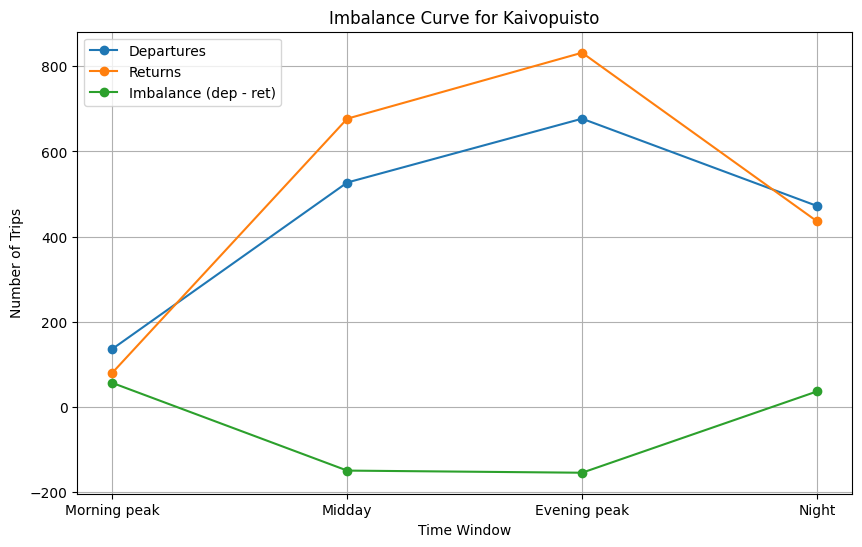

In [82]:
# ============================
# C. Imbalance & Operational Analysis
# 4.3 Imbalance Curves (Single Station Example)
# Report Section 4.3
# ============================

import matplotlib.pyplot as plt

# Choose station to plot (by name)
station_to_plot = "Kaivopuisto"

# Extract data for that station
station_data = temporal_balance_tw[temporal_balance_tw["dep_name"] == station_to_plot]

# Ensure time_window is ordered
time_order = ["Morning peak", "Midday", "Evening peak", "Night"]
station_data["time_window"] = pd.Categorical(station_data["time_window"], categories=time_order, ordered=True)

# Sort by time_window
station_data = station_data.sort_values("time_window")

# Plot departures, returns, imbalance
plt.figure(figsize=(10,6))
plt.plot(station_data["time_window"], station_data["departures"], label="Departures", marker="o")
plt.plot(station_data["time_window"], station_data["returns"],    label="Returns", marker="o")
plt.plot(station_data["time_window"], station_data["imbalance"],  label="Imbalance (dep - ret)", marker="o")

plt.title(f"Imbalance Curve for {station_to_plot}")
plt.xlabel("Time Window")
plt.ylabel("Number of Trips")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# EXPLANATION (for you):
# - This plot shows how departures, returns, and imbalance change during the day.
# - Morning emptying → positive imbalance.
# - Evening filling → negative imbalance.
# - Visual shape reveals typical daily station behavior.
#
# -------------------------------------------------------------
# SIMPLE REPORT INTERPRETATION:
#
# "Imbalance curves illustrate how each station’s load changes across the day.
#  For example, Kaivopuisto shows strong morning emptying (more departures),
#  followed by evening filling (more returns), consistent with a residential
#  commuting pattern. These curves help reveal temporal structure in station usage."
# -------------------------------------------------------------


Top stations to plot imbalance curves: ['Pasilan asema', 'Kalasatama (M)', 'Unioninkatu', 'Leppävaarankäytävä', 'Ympyrätalo']


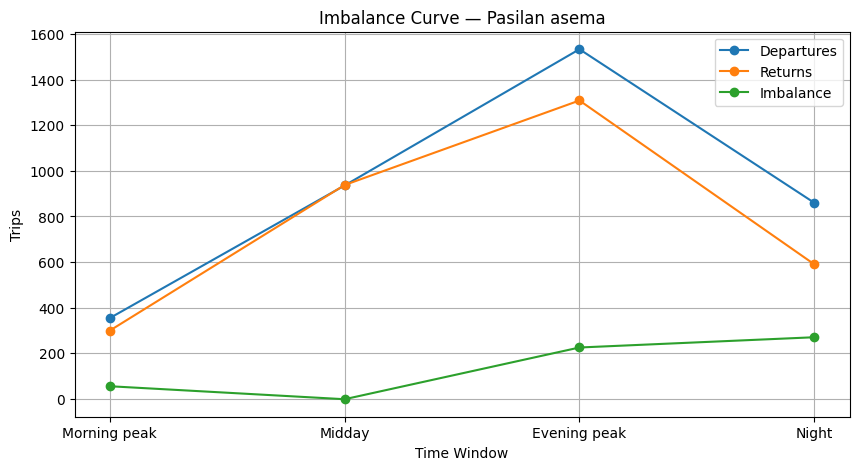

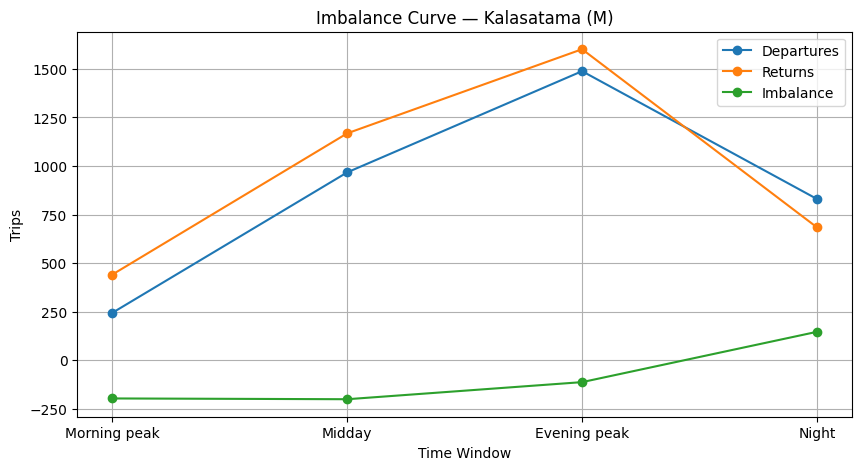

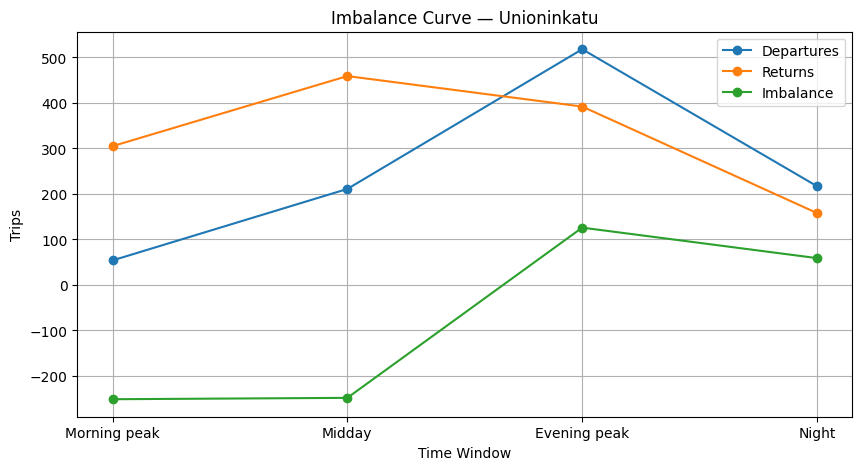

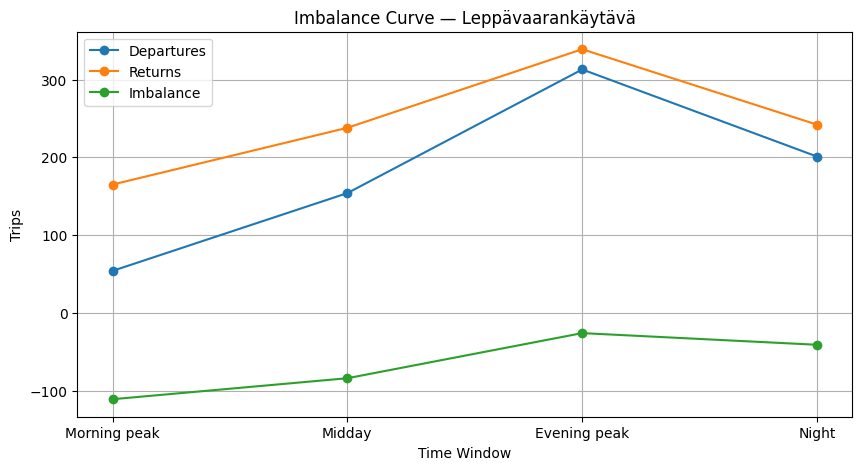

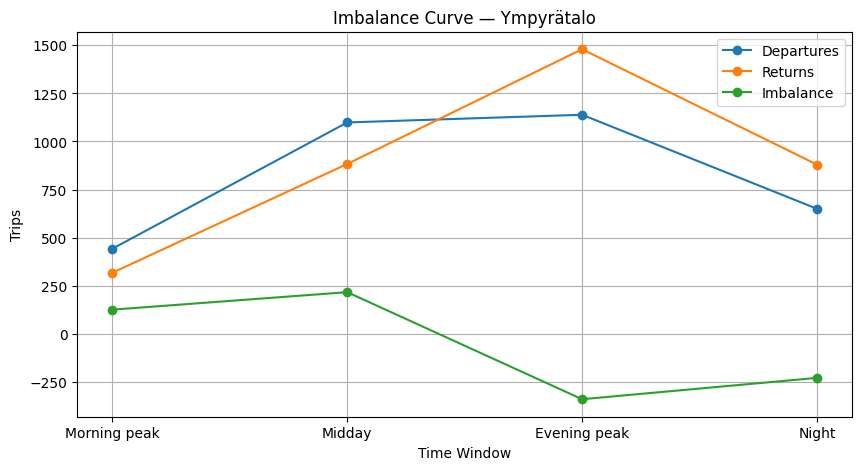

In [83]:
# ============================
# C. Imbalance & Operational Analysis
# 4.3 Imbalance Curves (Top N Stations)
# Report Section 4.3
# ============================

N = 5  # choose top N stations to visualize

# Select top N by absolute sum imbalance
top_stations = (
    imbalance_summary
    .set_index("dep_name")
    .reindex()  # ensure sorted properly
    .sort_values("sum_imbalance", key=lambda x: abs(x), ascending=False)
    .head(N)
    .index
)

print("Top stations to plot imbalance curves:", list(top_stations))

# Plot for each station
for station in top_stations:
    station_data = temporal_balance_tw[temporal_balance_tw["dep_name"] == station].copy()
    station_data["time_window"] = pd.Categorical(station_data["time_window"], categories=time_order, ordered=True)
    station_data = station_data.sort_values("time_window")

    plt.figure(figsize=(10,5))
    plt.plot(station_data["time_window"], station_data["departures"], label="Departures", marker="o")
    plt.plot(station_data["time_window"], station_data["returns"],    label="Returns", marker="o")
    plt.plot(station_data["time_window"], station_data["imbalance"],  label="Imbalance", marker="o")

    plt.title(f"Imbalance Curve — {station}")
    plt.xlabel("Time Window")
    plt.ylabel("Trips")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------------------------------------
# EXPLANATION (for you):
# - For each of the top N most imbalanced stations, we display the full daily curve.
# - Helps identify:
#       * morning draining stations
#       * evening filling stations
#       * midday stable stations
#       * stations that fluctuate unpredictably
#
# -------------------------------------------------------------
# SIMPLE REPORT INTERPRETATION:
#
# "We plotted imbalance curves for the top imbalanced stations.
#  The curves clearly reveal directional daily patterns such as
#  morning draining (outflow > inflow) and evening filling (inflow > outflow).
#  These temporal signatures help explain each station's operational challenges
#  and connect flow behavior to observed imbalances."
# -------------------------------------------------------------


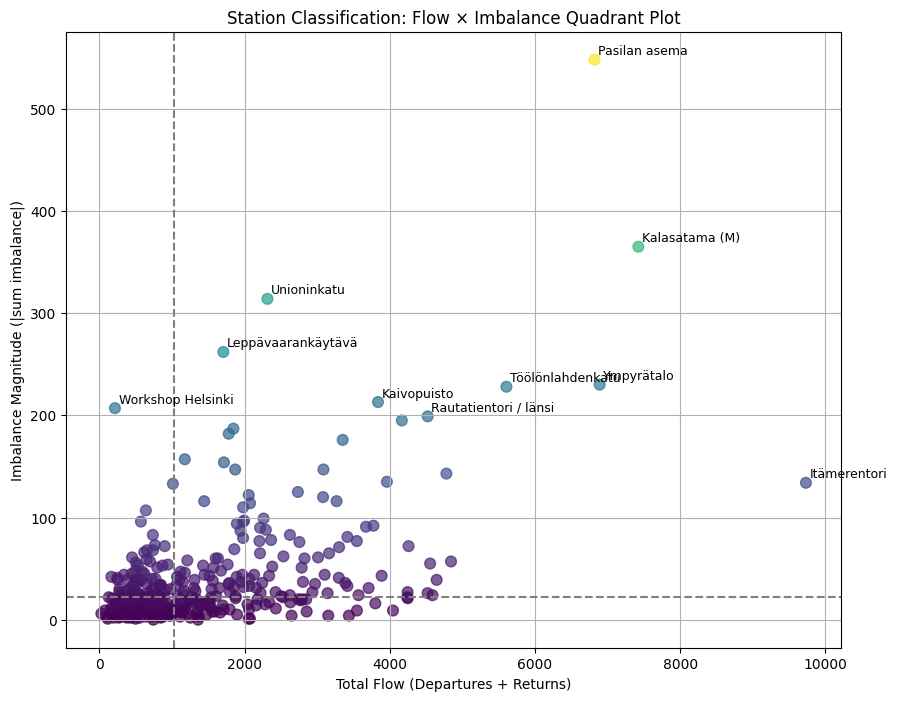

In [84]:
# ============================
# D. Station Classification
# 4.4 Flow × Imbalance Quadrant Plot (with Station Labels)
# Report Section 4.4
# ============================

import matplotlib.pyplot as plt

# ---- 1. Flow summary ----
flow_summary = (
    temporal_balance_tw.groupby(["dep_id", "dep_name"])[["departures", "returns"]]
                       .sum()
                       .reset_index()
)
flow_summary["total_flow"] = flow_summary["departures"] + flow_summary["returns"]

# ---- 2. Imbalance summary ----
imbalance_summary_full = imbalance_summary[["dep_id", "dep_name", "sum_imbalance"]].copy()
imbalance_summary_full["imbalance_magnitude"] = imbalance_summary_full["sum_imbalance"].abs()

# ---- 3. Merge flow + imbalance ----
profile = flow_summary.merge(
    imbalance_summary_full,
    on=["dep_id", "dep_name"]
)

# ---- 4. Thresholds (medians) ----
flow_threshold = profile["total_flow"].median()
imb_threshold = profile["imbalance_magnitude"].median()

# ---- 5. Classification ----
def classify(row):
    if row["total_flow"] >= flow_threshold and row["imbalance_magnitude"] >= imb_threshold:
        return "High Flow + High Imbalance (Critical)"
    elif row["total_flow"] >= flow_threshold and row["imbalance_magnitude"] < imb_threshold:
        return "High Flow + Low Imbalance (Stable High-Flow)"
    elif row["total_flow"] < flow_threshold and row["imbalance_magnitude"] >= imb_threshold:
        return "Low Flow + High Imbalance (Potential Issue)"
    else:
        return "Low Flow + Low Imbalance (Low-Activity Stable)"

profile["category"] = profile.apply(classify, axis=1)

# ---- 6. Quadrant plot ----
plt.figure(figsize=(10,8))
plt.scatter(
    profile["total_flow"],
    profile["imbalance_magnitude"],
    c=(profile["imbalance_magnitude"] / profile["imbalance_magnitude"].max()),
    cmap="viridis",
    alpha=0.7,
    s=60
)

plt.axvline(flow_threshold, color="gray", linestyle="--")
plt.axhline(imb_threshold, color="gray", linestyle="--")

plt.xlabel("Total Flow (Departures + Returns)")
plt.ylabel("Imbalance Magnitude (|sum imbalance|)")
plt.title("Station Classification: Flow × Imbalance Quadrant Plot")

# ============================
# 👉 LABEL ONLY OUTLIERS
# ============================

# Define an outlier rule:
# (adjustable, but this works well)
outlier_condition = (
    (profile["total_flow"] > flow_threshold * 8) |             # very high flow
    (profile["imbalance_magnitude"] > imb_threshold * 9)       # very high imbalance
)

outliers = profile[outlier_condition]

# Add labels
for _, row in outliers.iterrows():
    plt.text(
        row["total_flow"] + 50,   # slight offset to avoid overlap
        row["imbalance_magnitude"] + 5,
        row["dep_name"],
        fontsize=9,
        color="black"
    )

plt.grid(True)
plt.show()

# -------------------------------------------------------------
# EXPLANATION (for you):
# - We automatically detect outliers: stations with very high flow OR very high imbalance.
# - Only these points are labeled to avoid cluttering the plot.
# - This highlights the most critical stations in the network.
#
# -------------------------------------------------------------
# SIMPLE REPORT INTERPRETATION:
#
# "To make key stations more visible, we labeled only outliers with extremely
#  high flow or high imbalance. These stations represent the network’s most
#  critical pressure points and correspond to the strongest commuting or
#  directional movement corridors, explaining their imbalanced behavior."
# -------------------------------------------------------------


In [85]:
# ============================
# D. Station Classification
# 4.4 Station Classification (Flow × Imbalance)
# Report Section 4.4
# ============================

# ---- 1. Compute total flow (departures + returns) ----
flow_tw = (
    temporal_balance_tw.groupby(["dep_id", "dep_name"])
                       [["departures", "returns"]]
                       .sum()
)
flow_tw["total_flow"] = flow_tw["departures"] + flow_tw["returns"]

# ---- 2. Compute imbalance metrics: sum, mean, magnitude ----
imb_tw = (
    temporal_balance_tw.groupby(["dep_id", "dep_name"])["imbalance"]
)

imbalance_summary = imb_tw.agg(
    sum_imbalance="sum",          # raw net imbalance (+ = emptying, - = filling)
    mean_imbalance="mean",        # typical behavior per time window
    imbalance_magnitude=lambda x: abs(x.sum())  # absolute total pressure
)

# ---- 3. Combine flow + imbalance into one profile ----
station_profile = flow_tw.join(imbalance_summary)

# ---- 4. Thresholds for quadrant classification ----
flow_threshold = station_profile["total_flow"].median()
imb_threshold  = station_profile["imbalance_magnitude"].median()

# ---- 5. Assign categories ----
def classify_station(row):
    if row["total_flow"] >= flow_threshold and row["imbalance_magnitude"] >= imb_threshold:
        return "High Flow + High Imbalance (Critical)"
    elif row["total_flow"] >= flow_threshold and row["imbalance_magnitude"] < imb_threshold:
        return "High Flow + Low Imbalance (Stable High-Flow)"
    elif row["total_flow"] < flow_threshold and row["imbalance_magnitude"] >= imb_threshold:
        return "Low Flow + High Imbalance (Potential Issue)"
    else:
        return "Low Flow + Low Imbalance (Low-Activity Stable)"

station_profile["category"] = station_profile.apply(classify_station, axis=1)

# ---- 6. Automatically detect outlier stations ----
# (extreme flow or extreme imbalance)
outlier_condition = (
    (station_profile["total_flow"] > flow_threshold * 2) |
    (station_profile["imbalance_magnitude"] > imb_threshold * 2)
)

outliers = station_profile[outlier_condition].sort_values(
    by="imbalance_magnitude", ascending=False
).head(15)

print("=== Key Outlier Stations (Critical Attention) ===")
display(outliers[["total_flow", "sum_imbalance", "mean_imbalance",
                  "imbalance_magnitude", "category"]])

station_profile.head()

# -------------------------------------------------------------
# EXPLANATION (FOR YOU):
#
# This upgraded classification block now computes:
#   - total_flow           → how active the station is
#   - sum_imbalance        → net emptying/filling across the day
#   - mean_imbalance       → typical imbalance tendency (behavior)
#   - imbalance_magnitude  → total pressure on the system (absolute imbalance)
#
# These metrics together provide a full operational profile of each station.
#
# Quadrants are determined using median thresholds:
#   Q1: High Flow + High Imbalance  → CRITICAL STATIONS
#   Q2: High Flow + Low Imbalance   → HEALTHY HIGH-FLOW HUBS
#   Q3: Low Flow + High Imbalance   → POTENTIAL PROBLEM STATIONS
#   Q4: Low Flow + Low Imbalance    → STABLE LOW-ACTIVITY STATIONS
#
# Outliers (critical stations) are also extracted and printed automatically:
#   - Stations with exceptionally high flow
#   - OR exceptionally high imbalance magnitude
#
# -------------------------------------------------------------
# SIMPLE REPORT INTERPRETATION (PASTE IN REPORT):
#
# "To classify stations by operational behavior, we combined total flow
#  (a measure of activity level) with imbalance magnitude (a measure of
#  operational stress). Median thresholds divide stations into four
#  categories: (1) high-flow critical stations that exhibit strong
#  emptying or filling, (2) high-flow stable hubs, (3) low-flow stations
#  with high imbalance, and (4) low-activity stable stations.
#  We additionally detected extreme outlier stations that exceed twice the
#  median flow or imbalance, highlighting the key pressure points of the
#  system that drive redistribution workload."
# -------------------------------------------------------------



=== Key Outlier Stations (Critical Attention) ===


,,total_flow,sum_imbalance,mean_imbalance,imbalance_magnitude,category
dep_id,dep_name,,,,,
113.0,Pasilan asema,6820.0,548.0,137.00,548.0,High Flow + High Imbalance (Critical)
126.0,Kalasatama (M),7423.0,-365.0,-91.25,365.0,High Flow + High Imbalance (Critical)
11.0,Unioninkatu,2314.0,-314.0,-78.50,314.0,High Flow + High Imbalance (Critical)
731.0,Leppävaarankäytävä,1706.0,-262.0,-65.50,262.0,High Flow + High Imbalance (Critical)
41.0,Ympyrätalo,6890.0,-230.0,-57.50,230.0,High Flow + High Imbalance (Critical)
21.0,Töölönlahdenkatu,5606.0,-228.0,-57.00,228.0,High Flow + High Imbalance (Critical)
1.0,Kaivopuisto,3837.0,-213.0,-53.25,213.0,High Flow + High Imbalance (Critical)
997.0,Workshop Helsinki,213.0,207.0,51.75,207.0,Low Flow + High Imbalance (Potential Issue)
22.0,Rautatientori / länsi,4521.0,-199.0,-49.75,199.0,High Flow + High Imbalance (Critical)


,,departures,returns,total_flow,sum_imbalance,mean_imbalance,imbalance_magnitude,category
dep_id,dep_name,,,,,,,
1.0,Kaivopuisto,1812.0,2025.0,3837.0,-213.0,-53.25,213.0,High Flow + High Imbalance (Critical)
2.0,Laivasillankatu,627.0,609.0,1236.0,18.0,4.50,18.0,High Flow + Low Imbalance (Stable High-Flow)
3.0,Kapteeninpuistikko,1216.0,1164.0,2380.0,52.0,13.00,52.0,High Flow + High Imbalance (Critical)
4.0,Viiskulma,1405.0,1385.0,2790.0,20.0,5.00,20.0,High Flow + Low Imbalance (Stable High-Flow)
5.0,Sepänkatu,1536.0,1475.0,3011.0,61.0,15.25,61.0,High Flow + High Imbalance (Critical)


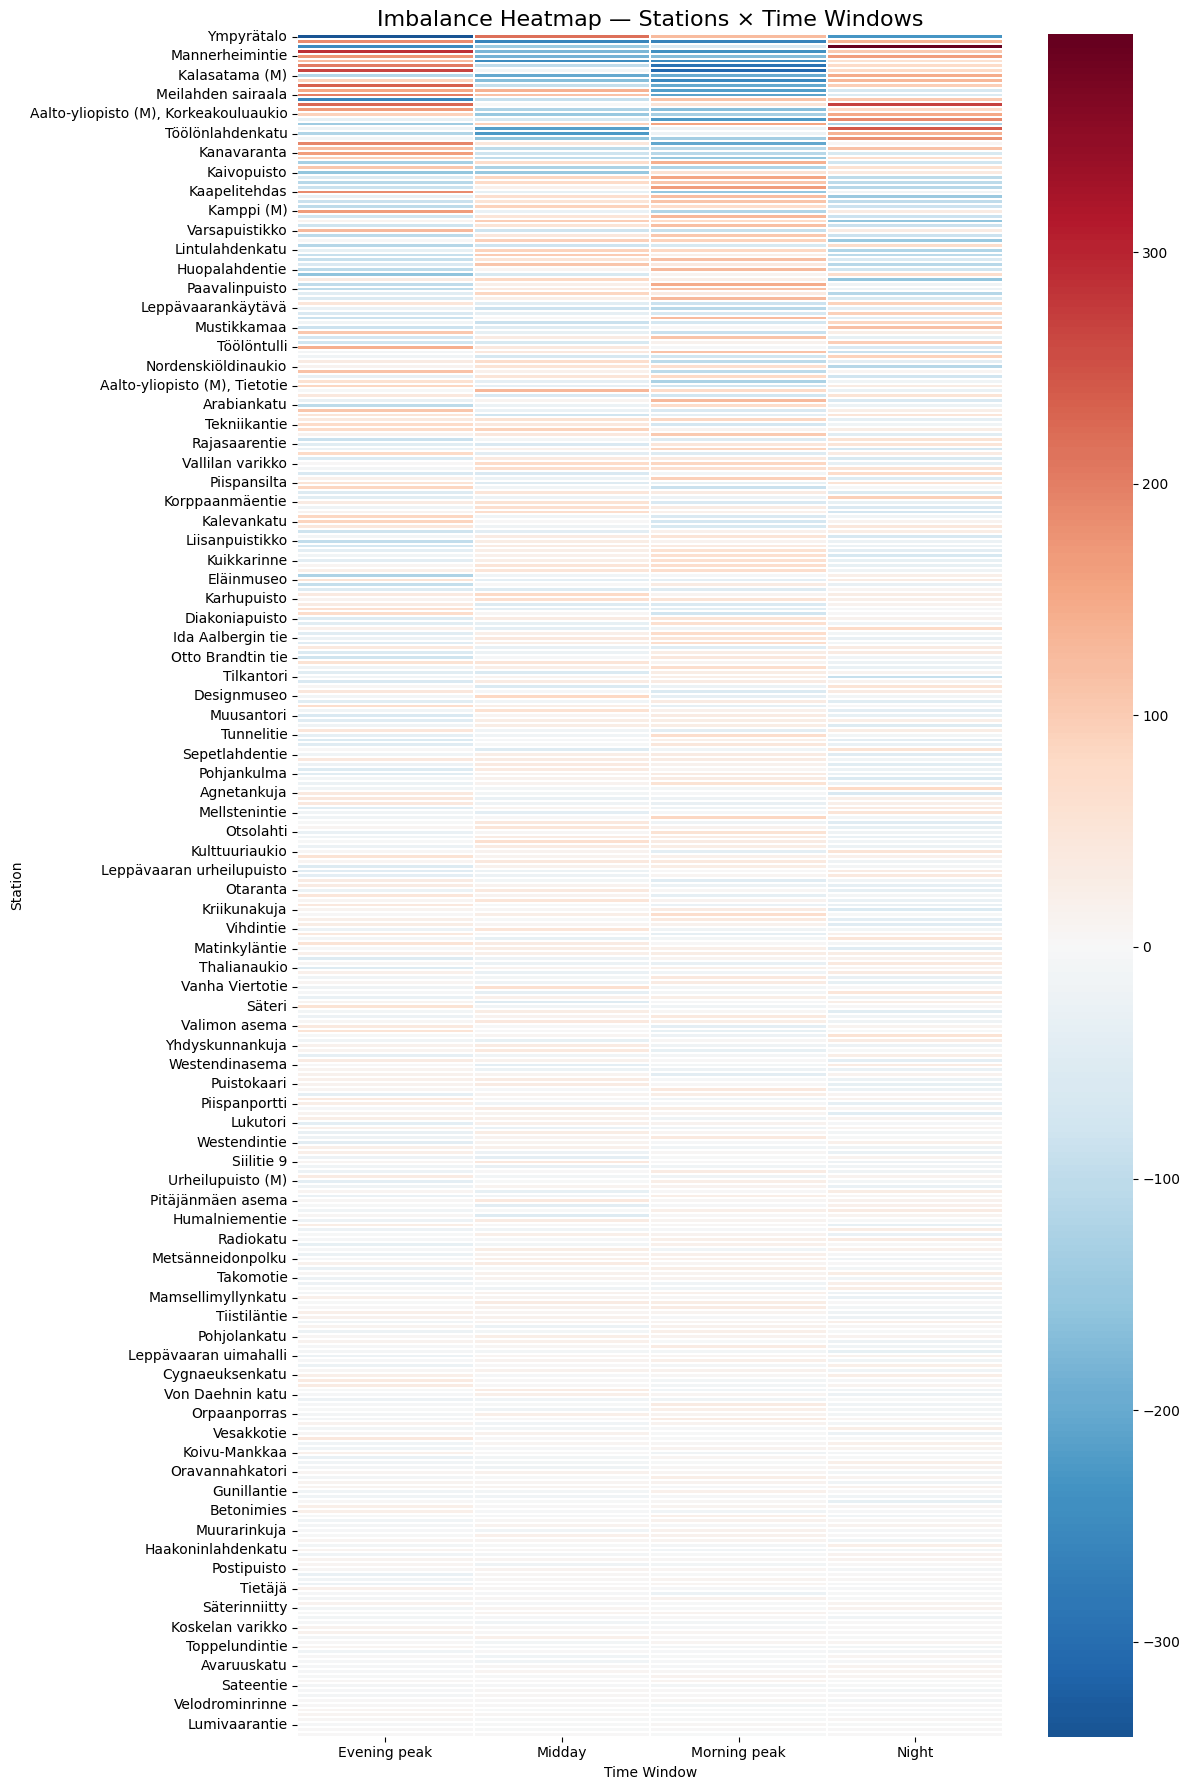

In [86]:
# ============================
# C. Imbalance & Operational Analysis
# 4.5A Heatmap: Station × Time Window → Imbalance
# Report Section 4.5
# ============================

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table: rows = stations, columns = time windows
heatmap_tw = temporal_balance_tw.pivot_table(
    index="dep_name",
    columns="time_window",
    values="imbalance",
    aggfunc="sum",
    fill_value=0
)

# Sort rows by total imbalance magnitude (helps readability)
row_order = heatmap_tw.abs().sum(axis=1).sort_values(ascending=False).index
heatmap_tw = heatmap_tw.loc[row_order]

plt.figure(figsize=(12, 18))
sns.heatmap(
    heatmap_tw,
    cmap="RdBu_r",          # red = positive (emptying), blue = negative (filling)
    center=0,
    linewidths=0.3
)
plt.title("Imbalance Heatmap — Stations × Time Windows", fontsize=16)
plt.xlabel("Time Window")
plt.ylabel("Station")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# EXPLANATION (for you):
# - Each row = a station.
# - Each column = a time window (Morning/Midday/Evening/Night).
# - Red cells: station empties (more departures than returns).
# - Blue cells: station fills (more returns than departures).
# - Darker colors → stronger imbalance.
#
# Why sort by imbalance magnitude?
# - Stations with largest imbalance appear at the top,
#   making the heatmap easier to interpret.
#
# -------------------------------------------------------------
# SIMPLE REPORT INTERPRETATION:
#
# "The time-window imbalance heatmap shows clear daily usage patterns
#  across stations. Red areas indicate periods where stations consistently
#  empty (outflow > inflow), while blue regions represent filling behavior.
#  Several strong patterns emerge, including morning emptying and evening
#  filling at major residential stations, and highly stable patterns at
#  central transit hubs. The heatmap highlights temporal structure and
#  operational pressure across the network."
# -------------------------------------------------------------


FLOW ANALYSIS

In [31]:
# ============================
# B. Flow Analysis
# 3.1 Top Flow Corridors (Strongest Weighted Edges)
# ============================

# Sort flow matrix by trip_count to get strongest connections
top_corridors = (
    flow_matrix.sort_values(by="trip_count", ascending=False)
               .head(20)   # choose top 20 strongest OD flows
)

# Add human-readable station names
top_corridors["dep_name"] = top_corridors["dep_id"].map(station_names)
top_corridors["ret_name"] = top_corridors["ret_id"].map(station_names)

top_corridors

#We extracted the 20 strongest station-to-station flows to identify major mobility corridors in the network. 
# The top edges represent the connections with the highest number of trips and form the weighted backbone of the bike-sharing system. 
# These strong corridors typically correspond to commuting routes between residential and work areas or popular leisure paths. 
# The presence of heavily used edges also helps explain imbalance patterns observed earlier
# since stations involved in high-volume flows tend to empty or fill during specific time windows.

,dep_id,ret_id,trip_count,dep_name,ret_name
28418,541,547,1113,"Aalto-yliopisto (M), Korkeakouluaukio",Jämeräntaival
28707,547,541,1064,Jämeräntaival,"Aalto-yliopisto (M), Korkeakouluaukio"
8542,64,30,334,Tyynenmerenkatu,Itämerentori
3972,30,64,319,Itämerentori,Tyynenmerenkatu
18417,134,126,275,Haukilahdenkatu,Kalasatama (M)
17311,126,122,270,Kalasatama (M),Lintulahdenkatu
17323,126,134,269,Kalasatama (M),Haukilahdenkatu
16697,122,126,235,Lintulahdenkatu,Kalasatama (M)
31558,711,727,219,Kirjurinkuja,Ratsutori
31910,727,711,218,Ratsutori,Kirjurinkuja


In [32]:
# ============================
# B. Flow Analysis
# 3.2 Outflow Strength vs Inflow Strength
# Report Section 3.2
# ============================

# ---- OUT-STRENGTH (total departures per station) ----
outflow_strength = (
    flow_matrix.groupby("dep_id")["trip_count"]
               .sum()
               .reset_index()
               .rename(columns={"trip_count": "outflow_strength"})
)

# ---- IN-STRENGTH (total returns per station) ----
inflow_strength = (
    flow_matrix.groupby("ret_id")["trip_count"]
               .sum()
               .reset_index()
               .rename(columns={"trip_count": "inflow_strength"})
)

# Merge for comparison
flow_strength = outflow_strength.merge(
    inflow_strength,
    left_on="dep_id",
    right_on="ret_id",
    how="outer"
)

flow_strength = flow_strength.fillna(0)  # if any station missing

# Add station names
flow_strength["station_name"] = flow_strength["dep_id"].map(station_names)

# Compute flow asymmetry (outflow - inflow)
flow_strength["flow_asymmetry"] = (
    flow_strength["outflow_strength"] - flow_strength["inflow_strength"]
)

# Sort for top inflow/outflow
top_outflow_stations = flow_strength.sort_values("outflow_strength", ascending=False).head(20)
top_inflow_stations  = flow_strength.sort_values("inflow_strength",  ascending=False).head(20)

flow_strength.head(), top_outflow_stations.head(), top_inflow_stations.head()

# -------------------------------------------------------------
# EXPLANATION OF THIS OUTPUT (for you):
# - outflow_strength: how many total trips START from each station.
# - inflow_strength: how many total trips END at each station.
# - flow_asymmetry = outflow - inflow:
#       positive → station sends more bikes than it receives (emptying behavior)
#       negative → station receives more bikes than it sends (filling behavior)
#
# - top_outflow_stations: stations with the highest number of departures.
# - top_inflow_stations: stations with the highest number of returns.
#
# This is the weighted version of degree centrality (node strength).
#
# -------------------------------------------------------------
# SIMPLE REPORT INTERPRETATION (paste into report):
#
# "We computed the weighted outflow and inflow strengths of each station,
#  representing the total number of trips departing from and arriving to each node.
#  Stations with high outflow strength act as major sources of movement,
#  while stations with high inflow strength serve as key destinations.
#  These values correspond to node strengths in a weighted directed network.
#  A comparison of inflow and outflow further reveals directional imbalances:
#  stations with positive outflow–inflow differences tend to empty,
#  while those with negative values tend to fill over time."
# -------------------------------------------------------------


(   dep_id  outflow_strength  ret_id  inflow_strength        station_name  \
 0       1              1812       1             2025         Kaivopuisto   
 1       2               627       2              609     Laivasillankatu   
 2       3              1216       3             1164  Kapteeninpuistikko   
 3       4              1405       4             1385           Viiskulma   
 4       5              1536       5             1475           Sepänkatu   
 
    flow_asymmetry  
 0            -213  
 1              18  
 2              52  
 3              20  
 4              61  ,
      dep_id  outflow_strength  ret_id  inflow_strength      station_name  \
 29       30              4799      30             4933      Itämerentori   
 110     113              3684     113             3136     Pasilan asema   
 123     126              3529     126             3894    Kalasatama (M)   
 40       41              3330      41             3560        Ympyrätalo   
 20       21            

In [33]:
# ============================
# B. Flow Analysis
# 3.3 Flow Asymmetry (Directional Bias)
# Report Section 3.3
# ============================

# We reuse the 'flow_strength' table from Phase 3.2
# If needed, recompute quickly:

# outflow_strength = flow_matrix.groupby("dep_id")["trip_count"].sum().reset_index().rename(columns={"trip_count":"outflow_strength"})
# inflow_strength = flow_matrix.groupby("ret_id")["trip_count"].sum().reset_index().rename(columns={"trip_count":"inflow_strength"})
# flow_strength = outflow_strength.merge(inflow_strength, left_on="dep_id", right_on="ret_id", how="outer").fillna(0)
# flow_strength["station_name"] = flow_strength["dep_id"].map(station_names)

# Compute flow asymmetry (already computed before but we rewrite for clarity)
flow_strength["flow_asymmetry"] = (
    flow_strength["outflow_strength"] - flow_strength["inflow_strength"]
)

# Sort to find most directionally biased stations
top_emptying_flow = flow_strength.sort_values("flow_asymmetry", ascending=False).head(15)
top_filling_flow  = flow_strength.sort_values("flow_asymmetry", ascending=True).head(15)

top_emptying_flow, top_filling_flow

# -------------------------------------------------------------
# EXPLANATION OF THIS OUTPUT (for you):
#
# flow_asymmetry = outflow_strength - inflow_strength
#
# Interpretation:
# - positive values → station sends out more bikes than it receives (STRONG OUTBOUND BIAS)
# - negative values → station receives more bikes than it sends (STRONG INBOUND BIAS)
#
# top_emptying_flow:
#   stations that experience the greatest outbound pressure.
#   these stations are prone to EMPTYING.
#
# top_filling_flow:
#   stations that experience the greatest inbound pressure.
#   these stations are prone to FILLING or OVERFLOW.
#
# This metric explains WHY some stations show imbalance:
#   structural directional flow leads to systematic emptying or filling.
#
# -------------------------------------------------------------
# SIMPLE REPORT INTERPRETATION (copy/paste):
#
# "To quantify directional movement patterns, we computed flow asymmetry for each station,
#  defined as the difference between total outflow and total inflow.
#  Stations with high positive asymmetry act as strong sources of bike trips and tend to empty
#  during busy periods, while stations with high negative asymmetry act as sinks and tend to fill.
#  This directional bias provides a structural explanation for several imbalance patterns
#  identified in earlier sections."
# -------------------------------------------------------------


(     dep_id  outflow_strength  ret_id  inflow_strength       station_name  \
 110     113              3684     113             3136      Pasilan asema   
 350     997               210     997                3  Workshop Helsinki   
 117     120               981     120              799        Mäkelänkatu   
 113     116              1763     116             1587         Linnanmäki   
 106     109               666     109              509     Hertanmäenkatu   
 42       43               934      43              780        Karhupuisto   
 86       87              1008      87              861        Kustaankatu   
 236     290               572     290              439   Vallilan varikko   
 112     115              1089     115              967      Venttiilikuja   
 81       82              1600      82             1480        Töölöntulli   
 41       42               779      42              663    Haapaniemenkatu   
 156     205               373     205              266      Ilm

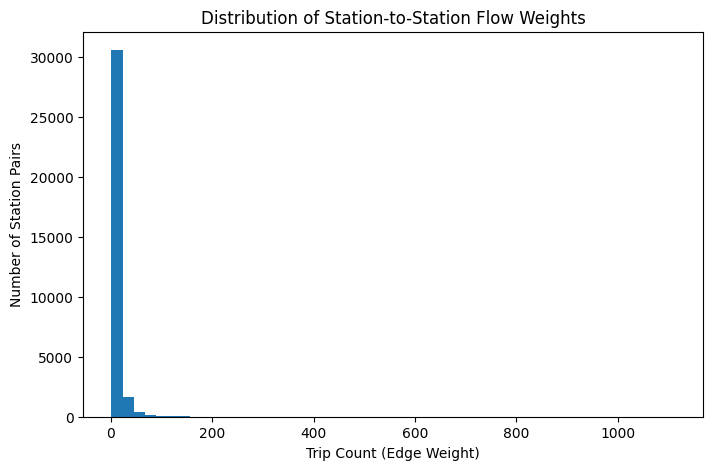

In [34]:
# ============================
# B. Flow Analysis
# 3.4 Flow Weight Distribution (Edge Weights)
# Report Section 3.4
# ============================

import matplotlib.pyplot as plt

# Extract all edge weights (trip counts)
edge_weights = flow_matrix["trip_count"]

# Plot histogram of flow weights
plt.figure(figsize=(8,5))
plt.hist(edge_weights, bins=50)
plt.xlabel("Trip Count (Edge Weight)")
plt.ylabel("Number of Station Pairs")
plt.title("Distribution of Station-to-Station Flow Weights")
plt.show()

# -------------------------------------------------------------
# EXPLANATION OF THIS OUTPUT (for you):
#
# - The histogram shows how many station pairs have small, medium, or large flows.
# - In bike networks, we typically see:
#       * many edges with very low trip counts
#       * very few edges with extremely high trip counts
# - This reveals whether the network has a heavy-tailed flow distribution.
#
# -------------------------------------------------------------
# SIMPLE REPORT INTERPRETATION (copy/paste):
#
# "We analyzed the distribution of edge weights (trip counts between station pairs).
#  The histogram shows that the majority of edges carry very few trips, while a small number
#  of connections carry disproportionately large volumes. This heavy-tailed pattern is typical
#  in bike-sharing networks, where a limited set of corridors dominates mobility.
#  These high-volume flows contribute strongly to the imbalance patterns observed earlier."
# -------------------------------------------------------------


In [35]:
flow_matrix[flow_matrix["trip_count"] > 200].sort_values("trip_count", ascending=False).head()


,dep_id,ret_id,trip_count
28418,541,547,1113
28707,547,541,1064
8542,64,30,334
3972,30,64,319
18417,134,126,275


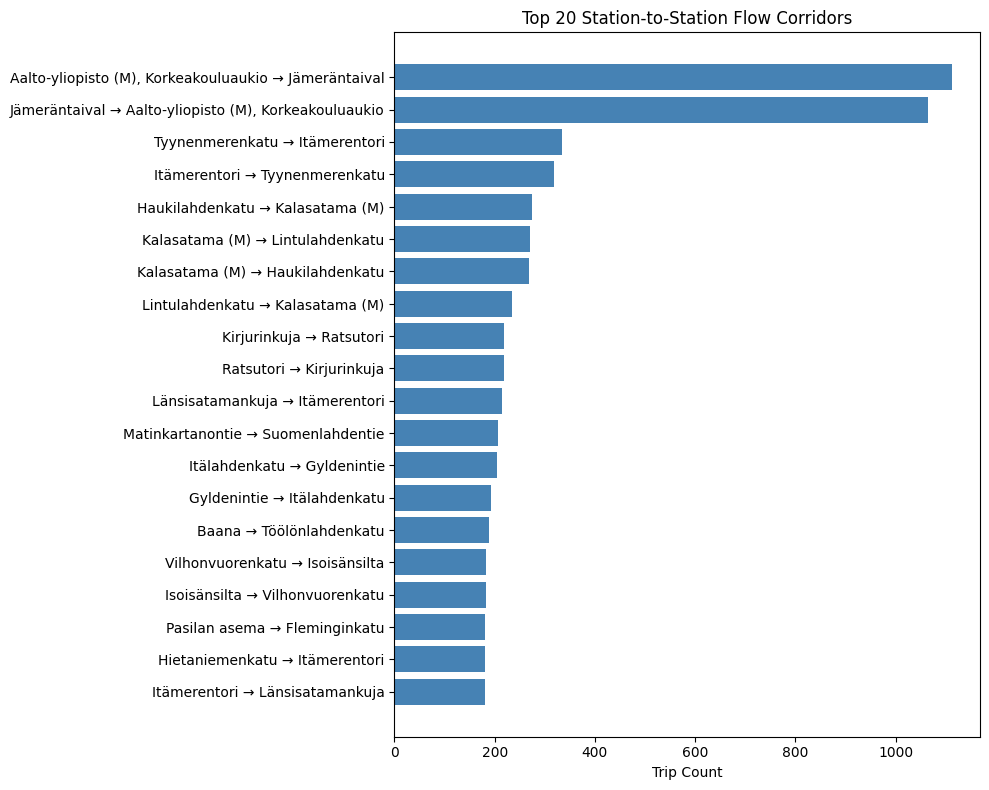

In [36]:
# ============================
# B. Flow Analysis
# 3.1 Flow Corridor Plot (Top N OD Flows)
# Report Section 3.1
# ============================

import matplotlib.pyplot as plt

# Extract top N strongest corridors
N = 20
top_corridors = (
    flow_matrix.sort_values("trip_count", ascending=False)
               .head(N)
               .copy()
)

# Add station names
top_corridors["dep_name"] = top_corridors["dep_id"].map(station_names)
top_corridors["ret_name"] = top_corridors["ret_id"].map(station_names)

# Create labels like "A → B"
top_corridors["label"] = top_corridors["dep_name"] + " → " + top_corridors["ret_name"]

plt.figure(figsize=(10,8))
plt.barh(top_corridors["label"], top_corridors["trip_count"], color="steelblue")
plt.xlabel("Trip Count")
plt.title(f"Top {N} Station-to-Station Flow Corridors")
plt.gca().invert_yaxis()   # highest at top
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# EXPLANATION (for you):
# - Shows top N OD pairs where trip_count is highest.
# - Horizontal bar plot is easiest to read with long station names.
#
# REPORT INTERPRETATION:
# "The top station-to-station flows reveal the key mobility corridors
#  in the bike-sharing system. These high-volume connections represent
#  dominant commuting or leisure routes and form the structural backbone
#  of bike movement in Helsinki."
# -------------------------------------------------------------


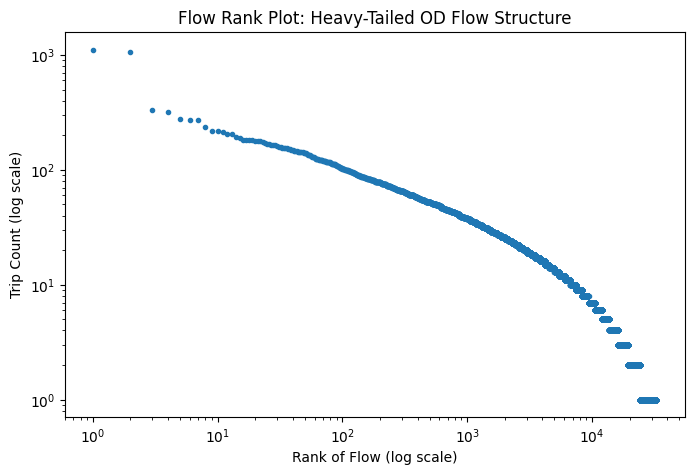

In [37]:
# ============================
# B. Flow Analysis
# 3.4 Flow Rank Plot (Heavy-Tailed Structure)
# Report Section 3.1 & 3.4
# ============================

import numpy as np
import matplotlib.pyplot as plt

weights = flow_matrix["trip_count"].sort_values(ascending=False).values
ranks = np.arange(1, len(weights)+1)

plt.figure(figsize=(8,5))
plt.plot(ranks, weights, marker='.', linestyle='none')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Rank of Flow (log scale)")
plt.ylabel("Trip Count (log scale)")
plt.title("Flow Rank Plot: Heavy-Tailed OD Flow Structure")
plt.show()

# -------------------------------------------------------------
# EXPLANATION:
# - Both axes are log scaled.
# - Shows classic heavy-tailed distribution (few large flows, many tiny flows).
#
# REPORT INTERPRETATION:
# "The flow rank plot shows that the OD flow distribution is heavy-tailed:
#  a small number of station pairs dominate total traffic, while most pairs
#  are used only a few times. This pattern is typical of urban mobility networks."
# -------------------------------------------------------------


In [ ]:
# ============================
# B. Flow Analysis
# 3.1 Flow Corridor Map (Improved Colors & Styling)
# ============================

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# Top corridors
N = 30
top_corr = flow_matrix.sort_values("trip_count", ascending=False).head(N).copy()

# Add coordinates
top_corr["dep_lat"] = top_corr["dep_id"].map(df.groupby("dep_id")["dep_lat"].first().to_dict())
top_corr["dep_lon"] = top_corr["dep_id"].map(df.groupby("dep_id")["dep_lon"].first().to_dict())
top_corr["ret_lat"] = top_corr["ret_id"].map(df.groupby("ret_id")["ret_lat"].first().to_dict())
top_corr["ret_lon"] = top_corr["ret_id"].map(df.groupby("ret_id")["ret_lon"].first().to_dict())

# Normalize weights for colormap
norm = colors.Normalize(vmin=top_corr["trip_count"].min(), vmax=top_corr["trip_count"].max())
colormap = cm.ScalarMappable(norm=norm, cmap='viridis')

# Base map
m = folium.Map(location=[df["dep_lat"].mean(), df["dep_lon"].mean()], zoom_start=12, tiles="cartodbpositron")

# Draw each corridor
for _, row in top_corr.iterrows():
    color = colors.to_hex(colormap.to_rgba(row["trip_count"]))  # convert to HEX color
    weight = 3 + (row["trip_count"] / top_corr["trip_count"].max()) * 8  # adaptive thickness

    folium.PolyLine(
        locations=[(row["dep_lat"], row["dep_lon"]),
                   (row["ret_lat"], row["ret_lon"])],
        color=color,
        weight=weight,
        opacity=0.85
    ).add_to(m)

# Save

print("Saved improved map → flow_corridors_better.html")

# Save to full, absolute path
output_path = "/Users/elifdeniz/Desktop/flow_corridors_better.html"   # <-- change if needed

m.save(output_path)
print("Saved map to:", output_path)




# -------------------------------------------------------------
# EXPLANATION:
# - Thick yellow/green lines = extremely heavy usage (hundreds or thousands of trips).
# - Thinner blue/purple lines = moderate usage.
#
# REPORT INTERPRETATION:
# "We visualized the top 30 station-to-station connections using a flow corridor map.
#  Each line represents a directed origin–destination flow, with color and thickness 
#  proportional to trip volume. The resulting map highlights several dominant mobility 
#  corridors that form the structural backbone of Helsinki’s bike-sharing network. 
#  These high-volume connections typically correspond to commuting routes between major 
#  residential areas, business centers, and transit hubs. The spatial concentration of 
#  strong corridors also helps explain the imbalance patterns observed earlier: stations 
#  located at the origins of strong flows tend to empty during peak hours, while stations 
#  at the destinations tend to fill."
# -------------------------------------------------------------


Saved improved map → flow_corridors_better.html
Saved map to: /Users/elifdeniz/Desktop/flow_corridors_better.html
